In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os
import inspect

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset

import itertools

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset


from tqdm import tqdm
from src.profiling import Timer

# Load and Format the Data

## Define Directories

In [3]:
# the directory to save pictures
path_to_save = 'raports/pics/cubical-torus-transpositions'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [4]:
# the directory to load transpositions data
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

## Check sizes of files

In [5]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_32370/4026766541.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 1529/1529 [00:00<00:00, 3568.63it/s]


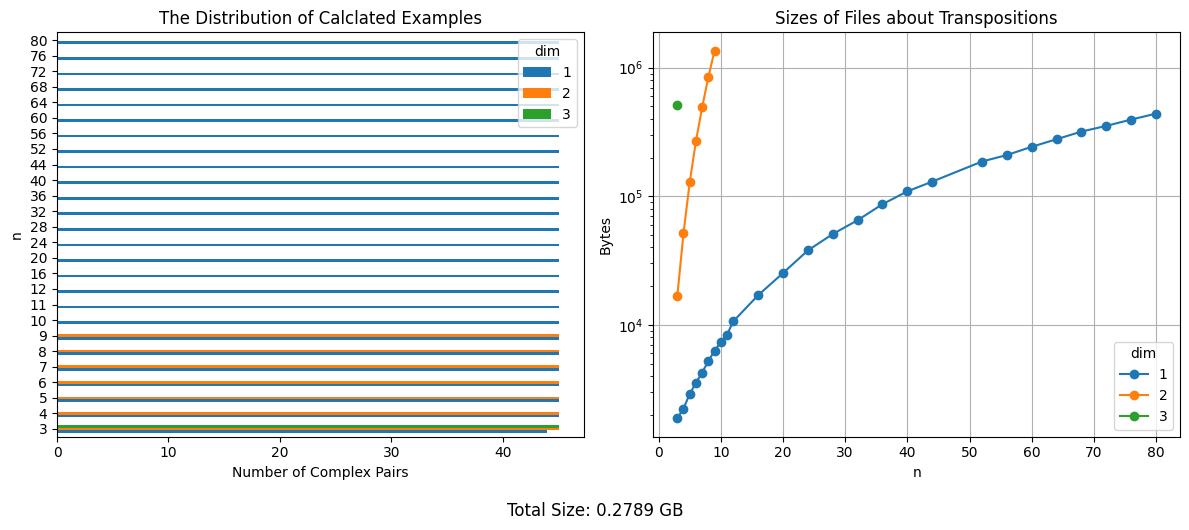

In [6]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

## Load Transpositions Data

In [7]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 1529/1529 [00:01<00:00, 863.47it/s]


df.shape = (2155923, 24)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,...,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.001931,0.431932,1.0,1.0,1.0,...,0.2,1.0,1.0,1,2,"((0,),)","((2,),)",0,birth-birth,no switch
1,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.022655,0.430177,1.0,1.0,1.0,...,1.0,1.0,1.0,0,1,"((1,),)","((2,),)",0,birth-unpaired,undefined
2,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.429125,1.571011,0.0,0.0,1.0,...,0.2,0.0,0.0,5,6,"((0,), (1,))","((3,), (0,))",1,death-death,no switch
3,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.719007,1.746056,0.0,1.0,0.0,...,1.0,0.0,1.0,6,7,"((0,), (1,))","((2,), (3,))",1,death-unpaired,undefined
4,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.771944,1,4,"(4,)",0.856378,0.898951,0.0,1.0,0.0,...,1.0,0.0,1.0,2,3,"((0,),)","((3,),)",0,birth-birth,switch backward


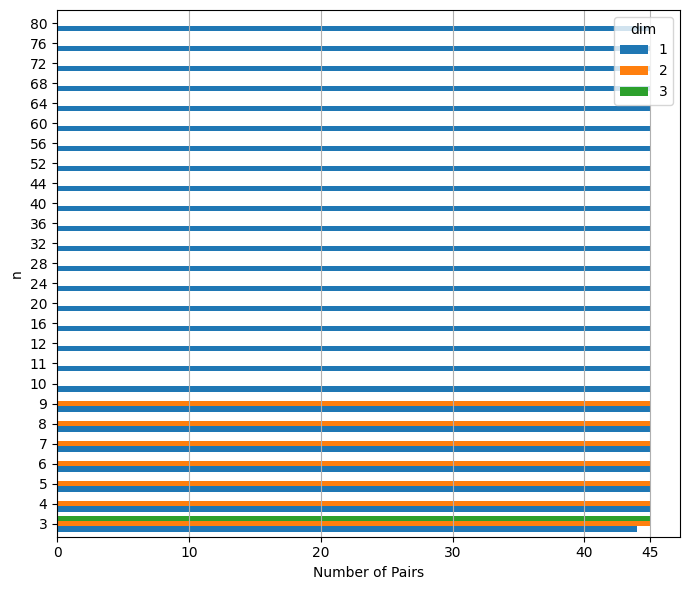

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))

df_to_plot = df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n'])['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().rename(columns=lambda s: s.replace('complex_', '')).pivot_table(columns='dim', index='n', values='index0').fillna(0).astype(int)
df_to_plot.plot(kind='barh', width=0.8, ax=ax)

ax.set_xlabel('Number of Pairs')

xticks = ax.get_xticks()
xticks = np.unique(np.append(xticks[xticks <= df_to_plot.max().max()], df_to_plot.max().max())).astype(int)

ax.set_xticks(xticks)

ax.grid(axis='x')

plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'distribution.png'))

# Switch Types Distribution

In [32]:
tqdm.pandas(desc="Define switch type from type and switch columns")
df['switch type'] = df.progress_apply(lambda row: row['type'] if row['switch'] in ['switch', 'switch backward', 'switch forward'] else row['switch'], axis=1)

df['switch type'].value_counts()

Define switch type from type and switch columns: 100%|██████████| 2155923/2155923 [00:13<00:00, 155813.36it/s]


switch type
no switch      2024184
undefined        50398
death-death      37207
birth-birth      37102
birth-death       7032
Name: count, dtype: int64

In [33]:
# define colors
switch_type_colors = {
    'birth-birth': '#1f77b4',    # синий — начало и начало, что-то "созидательное"
    'birth-death': '#2ca02c',    # зелёный — жизнь и смерть, естественный переход
    'death-death': '#d62728',    # красный — смерть и смерть, ассоциируется с концом
    'no switch': '#9467bd',      # фиолетовый — устойчивость, "застывшее" состояние
    'undefined': '#7f7f7f'       # серый — неопределённость
}
switch_type_colors = pd.Series(switch_type_colors)

switch_type_colors

birth-birth    #1f77b4
birth-death    #2ca02c
death-death    #d62728
no switch      #9467bd
undefined      #7f7f7f
dtype: object

In [34]:
df_switch_types = df.copy()

with Timer() as timer:
    #df_switch_types.loc[(df_switch_types['switch'] == 'switch forward') | (df_switch_types['switch'] == 'switch backward'), 'switch'] = 'switch'
    #tqdm.pandas(desc="Define switch type from type and switch columns")
    #df_switch_types['switch type'] = df_switch_types.progress_apply(lambda row: row['type'] if row['switch'] == 'switch' else row['switch'], axis=1)
    #print(f'Formated Switch Type in {timer.elapsed():.4f} seconds.')
    #timer.checkpoint()

    df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
    print(f'Calculated counts-values for each type in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    
    df_switch_types_mean = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
    df_switch_types_mean = df_switch_types_mean.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_mean.index.name = 'n'
    print(f'Calculated mean count in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    

    df_switch_types_std = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].std().reset_index()
    df_switch_types_std = df_switch_types_std.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_std.index.name = 'n'
    print(f'Calculated variation count in {timer.elapsed():.4f} seconds.')

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])


Calculated counts-values for each type in 0.5134 seconds.
Calculated mean count in 0.0063 seconds.
Calculated variation count in 0.0074 seconds.


<>:16: SyntaxWarning: invalid escape sequence '\;'
<>:16: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_32370/2431584988.py:16: SyntaxWarning: invalid escape sequence '\;'
  axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
Ploting: 100%|██████████| 12/12 [00:00<00:00, 133.36it/s]


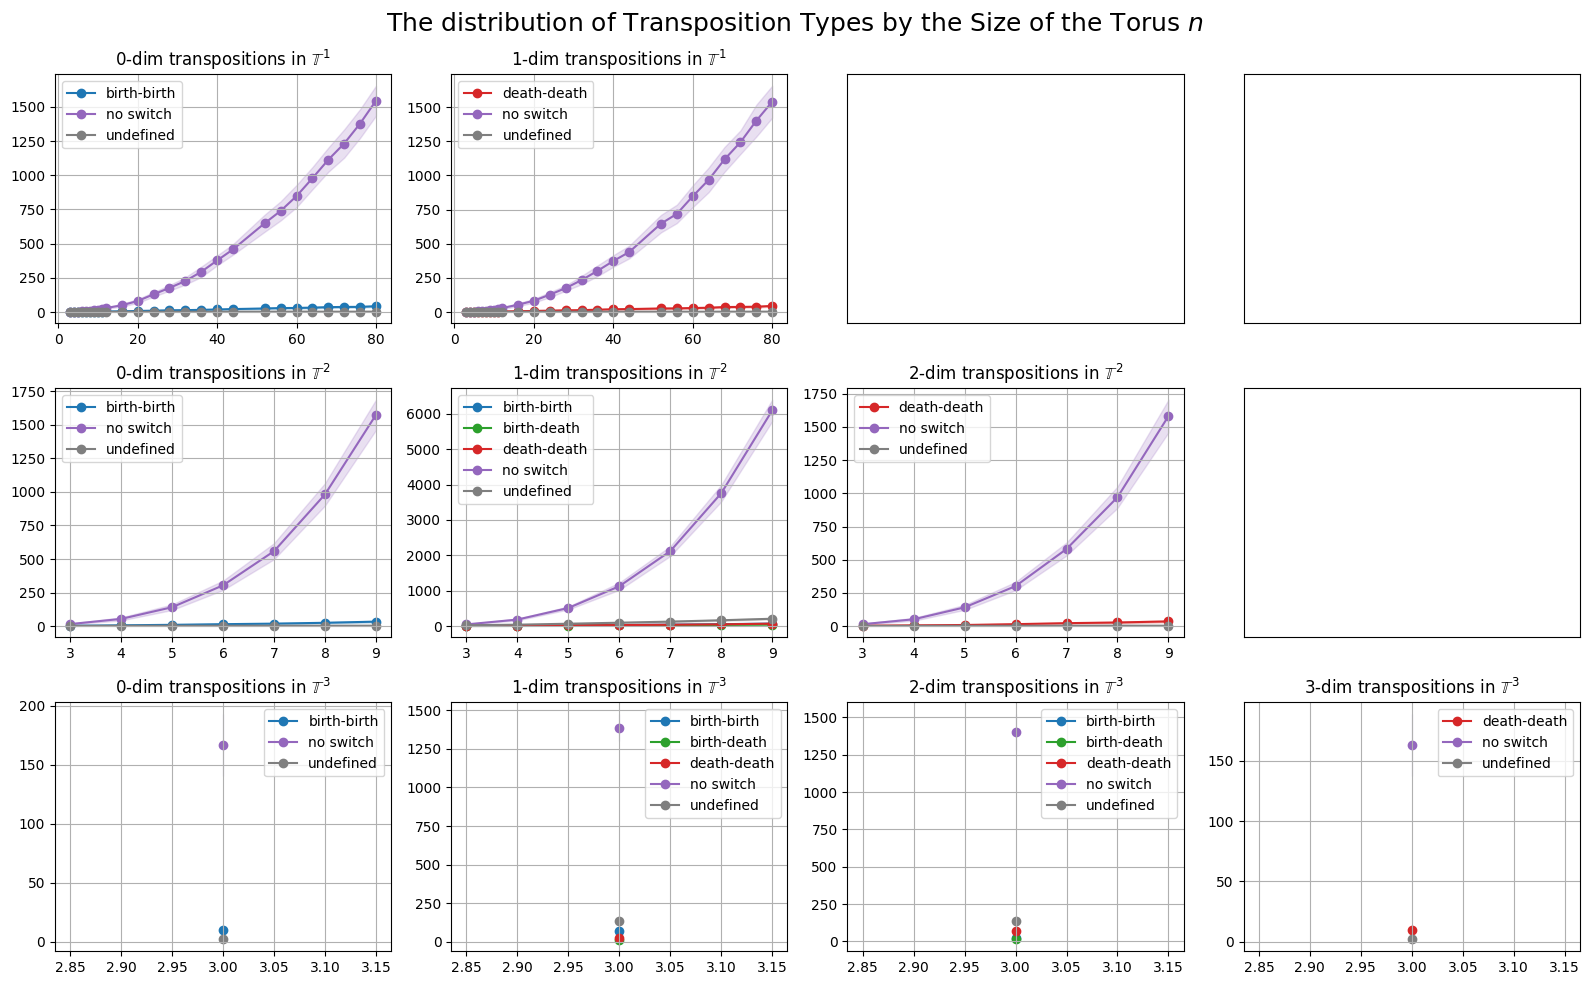

In [35]:
fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1), squeeze=False)
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$', fontsize=18)

for (i, complex_dim), (j, transposition_dim) in tqdm(itertools.product(enumerate(complex_dims), enumerate(transposition_dims)), 
                                                     total=len(complex_dims)*len(transposition_dims), desc='Ploting'):
    try:
        df_mean_to_plot = df_switch_types_mean[complex_dim][transposition_dim]
        df_std_to_plot = df_switch_types_std[complex_dim][transposition_dim]
        assert (df_mean_to_plot.columns == df_std_to_plot.columns).all()
        for col in df_mean_to_plot.columns:
            axs[i, j].plot(df_mean_to_plot[col], linestyle='-', marker='o', zorder=1, label=col, color=switch_type_colors[col])
            axs[i, j].fill_between(df_mean_to_plot.index, 
                                       df_mean_to_plot[col] - df_std_to_plot[col], 
                                       df_mean_to_plot[col] + df_std_to_plot[col], 
                                       alpha=0.2, zorder=0, color=switch_type_colors[col])
        axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
        axs[i, j].grid(True)
        axs[i, j].legend()
        #axs[i, j].set_xlabel('n')

    except KeyError:
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'switch-types.png'))

<>:16: SyntaxWarning: invalid escape sequence '\;'
<>:16: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_32370/65158957.py:16: SyntaxWarning: invalid escape sequence '\;'
  axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
Ploting: 100%|██████████| 12/12 [00:00<00:00, 186.15it/s]


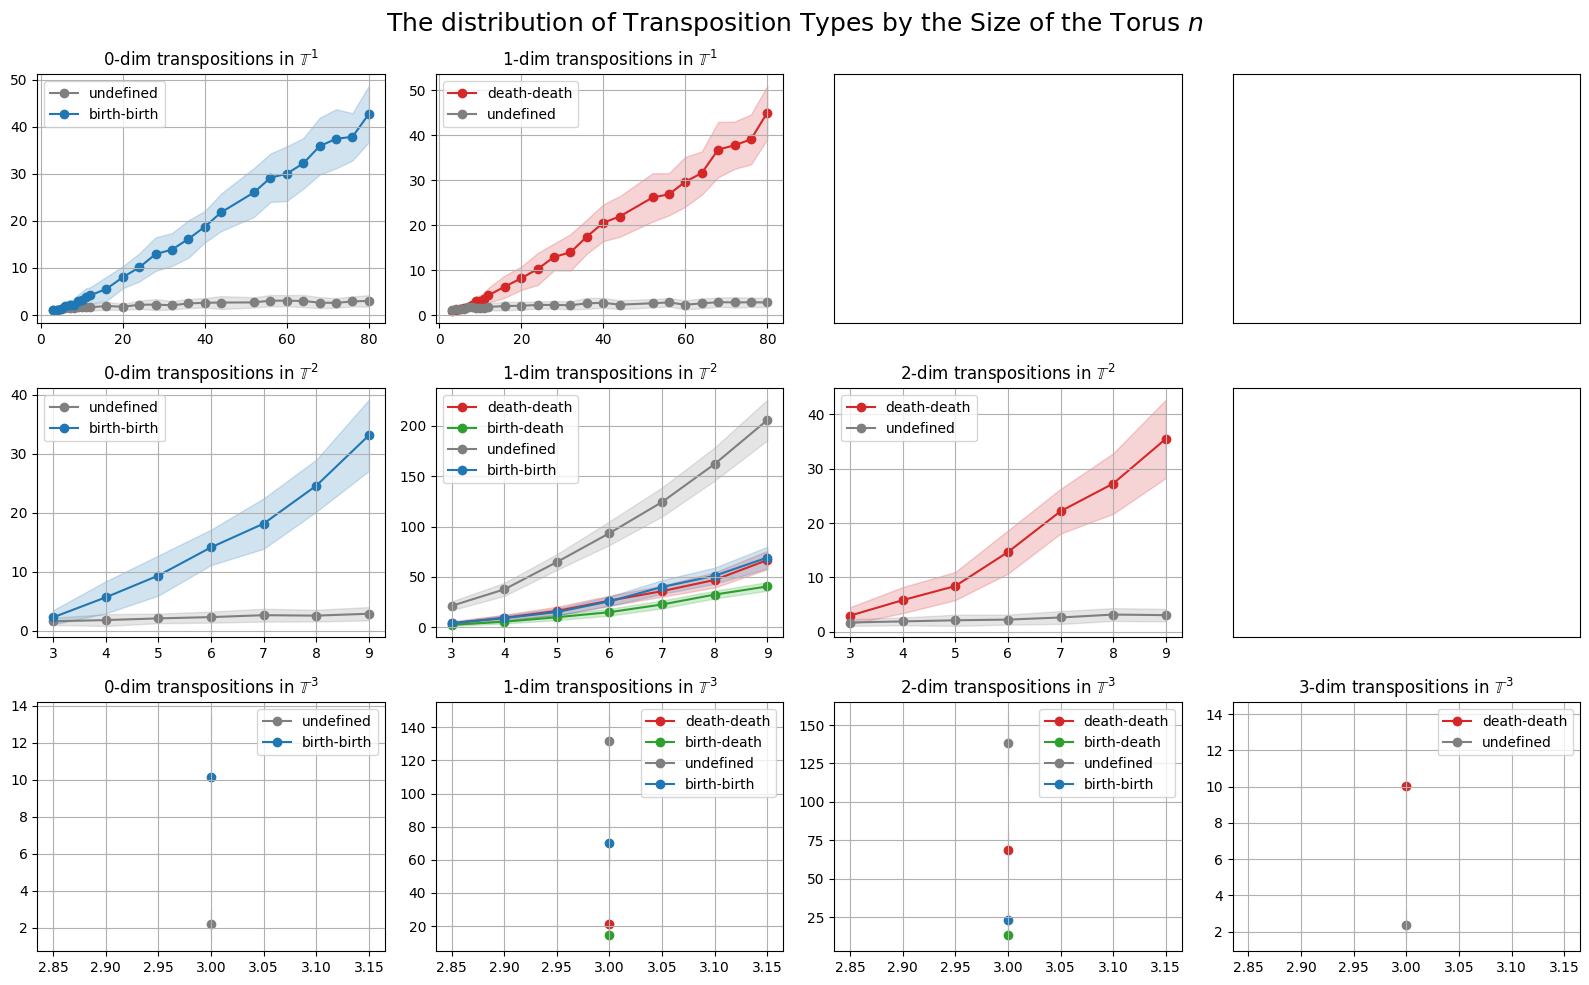

In [36]:
fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1), squeeze=False)
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$', fontsize=18)

for (i, complex_dim), (j, transposition_dim) in tqdm(itertools.product(enumerate(complex_dims), enumerate(transposition_dims)), 
                                                     total=len(complex_dims)*len(transposition_dims), desc='Ploting'):
    try:
        df_mean_to_plot = df_switch_types_mean[complex_dim][transposition_dim]
        df_std_to_plot = df_switch_types_std[complex_dim][transposition_dim]
        assert (df_mean_to_plot.columns == df_std_to_plot.columns).all()
        for col in set(df_mean_to_plot.columns) - {'no switch'}:
            axs[i, j].plot(df_mean_to_plot[col], linestyle='-', marker='o', zorder=1, label=col, color=switch_type_colors[col])
            axs[i, j].fill_between(df_mean_to_plot.index, 
                                       df_mean_to_plot[col] - df_std_to_plot[col], 
                                       df_mean_to_plot[col] + df_std_to_plot[col], 
                                       alpha=0.2, zorder=0, color=switch_type_colors[col])
        axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
        axs[i, j].grid(True)
        axs[i, j].legend()
        #axs[i, j].set_xlabel('n')

    except KeyError:
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'switch-types (without no switch).png'))

# The Changes of Depth Posets

In [37]:
from src import depth_poset_similarity_scores

In [60]:
similarity_scores = [name for name, func in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction) 
                     if func.__module__ == depth_poset_similarity_scores.__name__]

In [164]:
df_similarities_mean = df.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])[similarity_scores].mean()
df_similarities_mean = df_similarities_mean.reset_index()
df_similarities_mean = df_similarities_mean.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=similarity_scores, var_name='score', value_name='value')
df_similarities_mean = df_similarities_mean.pivot_table(index='complex_n', columns=['complex_dim', 'score', 'dim', 'switch type'], values='value')

print(f'df_similarities_mean.shape = {df_similarities_mean.shape}')
df_similarities_mean.head(10)

df_similarities_mean.shape = (26, 330)


complex_dim                              1                                  \
score       birth_relation_cell_similarity                                   
dim                                      0                               1   
switch type                    birth-birth no switch undefined death-death   
complex_n                                                                    
3                                 0.000000       1.0  0.416667    0.000000   
4                                 0.000000       1.0  0.590909    0.000000   
5                                 0.034146       1.0  0.313333    0.097561   
6                                 0.121973       1.0  0.394345    0.097094   
7                                 0.181430       1.0  0.393878    0.196722   
8                                 0.263597       1.0  0.462022    0.306437   
9                                 0.318193       1.0  0.467221    0.353985   
10                                0.340374       1.0  0.527214    0.409291   
11                                0.416795       1.0  0.547476    0.451827   
12                                0.443387       1.0  0.547164    0.480249   

complex_dim                                                                \
score                           birth_relation_index_similarity             
dim                                                           0             
switch type no switch undefined                     birth-birth no switch   
complex_n                                                                   
3            0.333333  0.594595                        1.000000  1.000000   
4            0.662447  0.539007                        1.000000  0.436364   
5            0.791375  0.547518                        0.758537  0.388969   
6            0.822907  0.540000                        0.790000  0.316998   
7            0.920113  0.482260                        0.667281  0.337546   
8            0.934209  0.504099                        0.770092  0.381227   
9            0.932922  0.466963                        0.777346  0.409713   
10           0.959260  0.578770                        0.793608  0.454383   
11           0.965511  0.517581                        0.794882  0.475977   
12           0.968608  0.621723                        0.794581  0.516883   

complex_dim                        ...                         3            \
score                              ... relation_index_similarity             
dim                             1  ...                         1             
switch type undefined death-death  ...                 no switch undefined   
complex_n                          ...                                       
3            0.416667    0.000000  ...                  0.911506  0.962281   
4            0.590909    0.078947  ...                       NaN       NaN   
5            0.313333    0.308943  ...                       NaN       NaN   
6            0.394345    0.489548  ...                       NaN       NaN   
7            0.393878    0.644977  ...                       NaN       NaN   
8            0.462022    0.674579  ...                       NaN       NaN   
9            0.467221    0.741811  ...                       NaN       NaN   
10           0.527214    0.750548  ...                       NaN       NaN   
11           0.547476    0.795458  ...                       NaN       NaN   
12           0.547164    0.810493  ...                       NaN       NaN   

complex_dim                                                          \
score                                                                 
dim                   2                                               
switch type birth-birth birth-death death-death no switch undefined   
complex_n                                                             
3              0.985893    0.966482    0.955208  0.911243  0.961703   
4                   NaN         NaN         NaN       NaN       NaN   
5    

In [165]:
df_similarities_std = df.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])[similarity_scores].std()
df_similarities_std = df_similarities_std.reset_index()
df_similarities_std = df_similarities_std.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=similarity_scores, var_name='score', value_name='value')
df_similarities_std = df_similarities_std.pivot_table(index='complex_n', columns=['complex_dim', 'score', 'dim', 'switch type'], values='value')

print(f'df_similarities_std.shape = {df_similarities_std.shape}')
df_similarities_std.head(10)

df_similarities_std.shape = (26, 330)


complex_dim                              1                                  \
score       birth_relation_cell_similarity                                   
dim                                      0                               1   
switch type                    birth-birth no switch undefined death-death   
complex_n                                                                    
3                                 0.000000       0.0  0.503610    0.000000   
4                                 0.000000       0.0  0.503236    0.000000   
5                                 0.095594       0.0  0.399319    0.158883   
6                                 0.144418       0.0  0.342853    0.171539   
7                                 0.160877       0.0  0.242782    0.184147   
8                                 0.184750       0.0  0.294646    0.214542   
9                                 0.161357       0.0  0.201237    0.217754   
10                                0.170897       0.0  0.225758    0.204629   
11                                0.168363       0.0  0.234704    0.210658   
12                                0.168799       0.0  0.192865    0.209645   

complex_dim                                                                \
score                           birth_relation_index_similarity             
dim                                                           0             
switch type no switch undefined                     birth-birth no switch   
complex_n                                                                   
3            0.479463  0.497743                        0.000000  0.000000   
4            0.452104  0.499048                        0.000000  0.500505   
5            0.332433  0.473233                        0.346873  0.460036   
6            0.287962  0.387924                        0.297729  0.361948   
7            0.151932  0.343855                        0.321523  0.259937   
8            0.134659  0.314862                        0.305436  0.252896   
9            0.123243  0.251086                        0.263034  0.214234   
10           0.095722  0.292208                        0.247612  0.224268   
11           0.080845  0.231023                        0.249166  0.194691   
12           0.076989  0.242214                        0.241853  0.182686   

complex_dim                        ...                         3            \
score                              ... relation_index_similarity             
dim                             1  ...                         1             
switch type undefined death-death  ...                 no switch undefined   
complex_n                          ...                                       
3            0.503610    0.000000  ...                  0.049372  0.039362   
4            0.503236    0.187317  ...                       NaN       NaN   
5            0.399319    0.243131  ...                       NaN       NaN   
6            0.342853    0.216200  ...                       NaN       NaN   
7            0.242782    0.123625  ...                       NaN       NaN   
8            0.294646    0.095605  ...                       NaN       NaN   
9            0.201237    0.092463  ...                       NaN       NaN   
10           0.225758    0.084839  ...                       NaN       NaN   
11           0.234704    0.057360  ...                       NaN       NaN   
12           0.192865    0.066950  ...                       NaN       NaN   

complex_dim                                                          \
score                                                                 
dim                   2                                               
switch type birth-birth birth-death death-death no switch undefined   
complex_n                                                             
3              0.012359    0.018066    0.027578  0.049773  0.040642   
4                   NaN         NaN         NaN       NaN       NaN   
5    

In [166]:
assert (df_similarities_std.columns == df_similarities_mean.columns).all()
assert (df_similarities_std.index == df_similarities_mean.index).all()

triples = df_similarities_mean.columns.droplevel(level=3)
triples = pd.DataFrame(list(triples.map(list).values), columns=list(triples.names))
triples = triples.drop_duplicates().reset_index(drop=True)
triples

,complex_dim,score,dim
0,1,birth_relation_cell_similarity,0
1,1,birth_relation_cell_similarity,1
2,1,birth_relation_index_similarity,0
3,1,birth_relation_index_similarity,1
4,1,death_relation_cell_similarity,0
...,...,...,...
85,3,relation_cell_similarity,3
86,3,relation_index_similarity,0
87,3,relation_index_similarity,1
88,3,relation_index_similarity,2


Generating Pictures about Similarities:   0%|          | 0/30 [00:00<?, ?it/s]

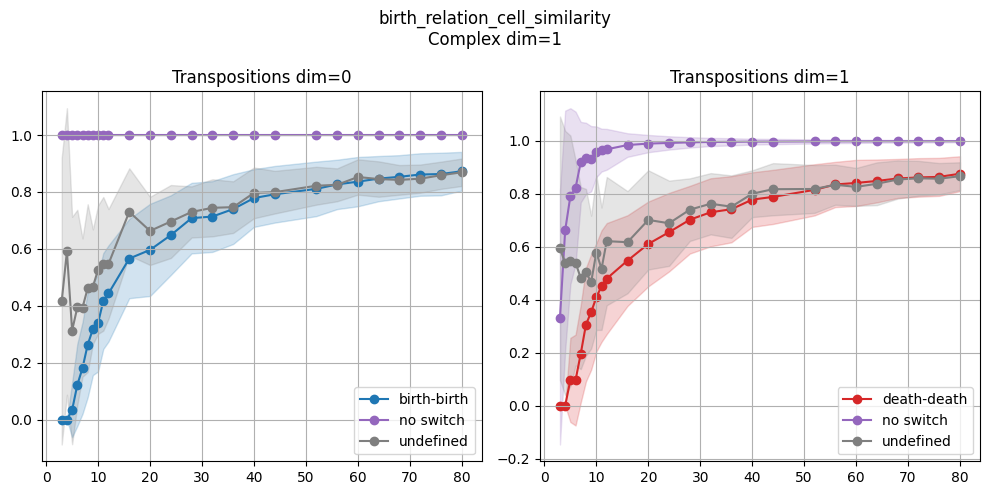

Generating Pictures about Similarities: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


In [196]:
path_temmplate = 'raports/pics/cubical-torus-transpositions/similaritites/complex dim={complex_dim} score={score}.png'
if not os.path.exists(path_temmplate[:path_temmplate.rfind('/')]):
    os.makedirs(path_temmplate[:path_temmplate.rfind('/')])

triples_grouped = triples.groupby(['complex_dim', 'score']).agg(list)


for iteration, ((complex_dim, score), row) in tqdm(enumerate(triples_grouped.iterrows()), total=len(triples_grouped), desc='Generating Pictures about Similarities'):
    dims = np.array(row['dim']).astype(int)

    path = path_temmplate.format(complex_dim=complex_dim, score=score)
    
    fig, axs = plt.subplots(1, len(dims), figsize=(5*len(dims), 5), squeeze=False)
    fig.suptitle(f'{score}\nComplex dim={complex_dim}')
    for idim, dim in enumerate(dims):
        axs[0, idim].set_title(f'Transpositions dim={dim}')
        df_mean_to_plot = df_similarities_mean[complex_dim][score][dim]
        df_std_to_plot = df_similarities_std[complex_dim][score][dim]
        assert (df_mean_to_plot.columns == df_std_to_plot.columns).all()
        for col in df_mean_to_plot.columns:
            axs[0, idim].plot(df_mean_to_plot[col], linestyle='-', marker='o', zorder=1, label=col, color=switch_type_colors[col])
            axs[0, idim].fill_between(df_mean_to_plot.index, 
                                      df_mean_to_plot[col] - df_std_to_plot[col], 
                                      df_mean_to_plot[col] + df_std_to_plot[col], 
                                      alpha=0.2, zorder=0, color=switch_type_colors[col])
        axs[0, idim].legend()
        axs[0, idim].grid(True)
    plt.tight_layout()
    plt.savefig(path)
    if iteration == 0:
        plt.show()
    plt.close()